# Chạy bisections

In [ ]:
import numpy as np


class POPOP():
    def __init__(self, variation_function, evaluation_function, pool_over_pop_size=2, selection_pressure=2):
        self.variate = variation_function
        self.evaluation_function = evaluation_function
        self.pool_over_pop_size = pool_over_pop_size
        self.selection_pressure = selection_pressure

    def evaluate(self, ind):
        self.n_eval_call += 1
        return self.evaluation_function(ind)

    def tournament_selection(self, pool, pool_fitness):
        pool_size = pool.shape[0]
        group_size = self.pool_over_pop_size * self.selection_pressure
        assert pool_size >= group_size and pool_size % group_size == 0

        new_pop = []
        new_pop_fitness = []

        for i in range(self.selection_pressure):
            shuffled_idx = np.random.permutation(pool_size)

            for j in range(0, pool_size, group_size):
                group_idx = shuffled_idx[j:j + group_size]
                group_fitness = pool_fitness[group_idx]
                winner_idx = group_idx[group_fitness.argmax()]
                new_pop.append(pool[winner_idx])
                new_pop_fitness.append(pool_fitness[winner_idx])

                # print(pool[group_idx])
                # print(group_fitness)

        new_pop = np.array(new_pop)
        new_pop_fitness = np.array(new_pop_fitness)
        # print()
        # print(new_pop)
        # print(new_pop_fitness)
        # print('####################')

        return new_pop, new_pop_fitness

    def __call__(self, population, num_generations=float('+inf'), verbose=0):
        self.n_eval_call = 0
        self.converged_generation = None
        
        pop = population
        pop_fitness = np.array([self.evaluate(ind) for ind in pop])
        if verbose:
            print('#First Population:')
            print(pop)
            print("#Gen 0:")
            print(pop_fitness)

        generation = 0
        while generation < num_generations:
            offspring = self.variate(pop, self.pool_over_pop_size)
            offspring_fitness = np.array([self.evaluate(ind) for ind in offspring])
            pool = np.vstack((pop, offspring))
            pool_fitness = np.hstack((pop_fitness, offspring_fitness))
            pop, pop_fitness = self.tournament_selection(pool, pool_fitness)
            # print()
            # print(pool)
            # print(pop)
            # print(pool_fitness)
            # print(pop_fitness)
            # print("#############")

            generation += 1
            if verbose:
                print(f"#Gen {generation}:")
                print(pop_fitness)

            if np.all(pop == pop[0]):
                if verbose:
                    print("Population converged")
                self.converged_generation = generation
                break

        best_idx = pop_fitness.argmax()
        self.best_ind = pop[best_idx]
        self.best_fitness = pop_fitness[best_idx]
        if verbose:
            print('#Best Individual:')
            print(self.best_ind)

        return self.best_ind


In [ ]:
import yaml
from pathlib import Path
from tqdm import tqdm


def initialize_population( num_individuals, num_variables ):
    """
    Khởi tạo quần thể gồm num_individuals cá thể. Mỗi cá thể có num_variables biến.
    
    Arguments:
    num_individuals -- Số lượng cá thể
    num_variables -- Số lượng biến
    
    Returns:
    pop -- Ma trận (num_individuals, num_variables ) chứa quần thể mới được khởi tạo ngẫu nhiên.
    """
    assert num_individuals >= 2
    zeros = np.zeros((num_individuals//2, num_variables), dtype=np.int32)
    ones = np.ones((num_individuals - num_individuals//2, num_variables), dtype=np.int32)
    pop = np.vstack((zeros,ones))
    for i in range(num_variables):
        np.random.shuffle(pop[:,i])

    return pop


def onemax( ind ):
    """
    Hàm đánh giá OneMax: Đếm số bit 1 trong chuỗi nhị phân (cá thể ind).
    
    Arguments:
    ind -- Cá thể cần được đánh giá.

    Returns:
    value -- Giá trị của cá thể ind.
    """
    
    return np.sum(ind)


def uniform_crossover(pop, pool_over_pop_size):
    num_individuals = pop.shape[0]
    num_variables = pop.shape[1]

    offspring = pop.copy()
    for i in range(pool_over_pop_size - 2):
        offspring = np.vstack((offspring, pop.copy()))
    np.random.shuffle(offspring)

    assert num_individuals % 2 == 0
    for j in range(0, num_individuals, 2):
        # print(offspring[j])
        # print(offspring[j+1])

        is_swapped = np.zeros(num_variables)
        for gene in range(0, num_variables):
            r = np.random.rand()
            if r < 0.5:
                is_swapped[gene] = 1
                # print(gene, end=' ')
                temp = offspring[j+1][gene].copy()
                offspring[j+1][gene] = offspring[j][gene]
                offspring[j][gene] = temp

        if np.all(is_swapped == is_swapped[0]):
            gene = np.random.randint(num_variables)
            is_swapped[gene] = 1 - is_swapped[gene]
            # print()
            # print(gene, end=' ')
            temp = offspring[j+1][gene].copy()
            offspring[j+1][gene] = offspring[j][gene]
            offspring[j][gene] = temp

        # print()
        # print(offspring[j])
        # print(offspring[j+1])
        # print()

    return offspring


def one_point_crossover(pop, pool_over_pop_size):
    num_individuals = pop.shape[0]
    num_variables = pop.shape[1]

    offspring = pop.copy()
    for i in range(pool_over_pop_size - 2):
        offspring = np.vstack((offspring, pop.copy()))
    np.random.shuffle(offspring)

    assert num_individuals % 2 == 0
    for j in range(0, num_individuals, 2):
        # print(offspring[j])
        # print(offspring[j+1])

        idx = np.random.randint(1, num_variables)
        temp = offspring[j][idx:].copy()
        # print(temp)
        offspring[j][idx:] = offspring[j+1][idx:]
        offspring[j+1][idx:] = temp
        # print(temp)

        # print(idx)
        # print(offspring[j])
        # print(offspring[j+1])
        # print()

    return offspring


def trap_5(ind):
    k = 5
    num_variables = ind.shape[0]
    assert num_variables % k == 0

    score = 0
    for i in range(0, num_variables, k):
        n_one = np.sum(ind[i:i+k])
        score += n_one if n_one == k else (k-1) - n_one
    
    return score

def check_optimality(num_variables, ind):
    return np.sum(ind) == num_variables

def one_bisection(seeds, algo, num_variables, check_optimality, group_size=4, lower=4, upper=8192):
    invalid_upper = upper + 1
    upper += 1

    while lower < upper:
        pop_size = lower + (upper - lower) // 2
        pop_size -= pop_size % group_size
        assert pop_size >= lower
        
        is_succeed = False
        for i, seed in enumerate(seeds):
            np.random.seed(seed)
            pop = initialize_population(pop_size, num_variables)
            converged_solutoin = algo(pop)
            is_succeed = check_optimality(num_variables, converged_solutoin)
            if is_succeed == False:
                break

        if is_succeed == False:
            lower = pop_size + group_size
        else:
            upper = pop_size
    
    if upper == invalid_upper:
        return None, None
    mrps = upper
    sum_n_eval_call = 0
    for i, seed in enumerate(seeds):
        np.random.seed(seed)
        pop = initialize_population(mrps, num_variables)
        algo(pop)
        sum_n_eval_call += algo.n_eval_call
    mean_n_eval_call = sum_n_eval_call / len(seeds)

    return mrps, mean_n_eval_call

In [ ]:
save_dir = Path('/content/drive/MyDrive/CS410 - Assignment 2')

In [ ]:
# # # # # # # # # # # bisection_seeds = np.arange(20520864, 20520864 + 100)
# # # # # # # # # # # bisection_seeds = bisection_seeds.reshape(10, -1).tolist()
# # # # # # # # # # # lst_problem_size = [10, 20, 40, 80, 160]
# # # # # # # # # # # lst_variation = ['one_point_crossover', 'uniform_crossover']
# # # # # # # # # # # lst_problem = ['onemax', 'trap_5']
# # # # # # # # # # # data = dict()

# # # # # # # # # # # for problem in lst_problem:
# # # # # # # # # # #     for variation in lst_variation:
# # # # # # # # # # #         for problem_size in lst_problem_size:
# # # # # # # # # # #             key = (problem, variation, problem_size)
# # # # # # # # # # #             value = {
# # # # # # # # # # #                 'bisection_seeds': bisection_seeds,
# # # # # # # # # # #                 'mrps\'': [],
# # # # # # # # # # #                 'mean_n_eval_calls': [],
# # # # # # # # # # #             }
# # # # # # # # # # #             data[key] = value

# # # # # # # # # # # with open(save_dir/'data.yaml', 'wt') as f:
# # # # # # # # # # #     yaml.dump(data, f)

In [ ]:
group_size = 4
lower = 4
upper = 8192
lst_problem_size = np.array([10, 20, 40, 80, 160])
lst_variation = ['one_point_crossover', 'uniform_crossover']
lst_problem = ['onemax', 'trap_5']

In [ ]:
with open(save_dir/'data.yaml', 'rt') as f:
    data = yaml.unsafe_load(f)

for problem in lst_problem:
    for variation in lst_variation:
        for problem_size in lst_problem_size:
            key = (problem, variation, problem_size)
            value = data[key]
            bisection_seeds = value['bisection_seeds']
            mrpss = value['mrps\'']
            mean_n_eval_calls = value['mean_n_eval_calls']
            assert len(mrpss) == len(mean_n_eval_calls)
            assert len(bisection_seeds) == 10
            assert len(bisection_seeds[0]) == 10
            print()
            print(key)
            for i in tqdm(range(len(mrpss), 10)):
                seeds = bisection_seeds[i]
                algo = POPOP(variation_function=globals()[variation], evaluation_function=globals()[problem])
                mrps, mean_n_eval_call = one_bisection(seeds, algo, problem_size, check_optimality, group_size=group_size, lower=lower, upper=upper)

                if mrps == None or mean_n_eval_call == None:
                    assert mean_n_eval_call == None and mrps == None
                    for psize in lst_problem_size[lst_problem_size >= problem_size]:
                        data[(problem, variation, psize)]['mrps\''] = [None] * 10
                        data[(problem, variation, psize)]['mean_n_eval_calls'] = [None] * 10
                    with open(save_dir/'data.yaml', 'wt') as f:
                        yaml.dump(data, f)
                    break
                
                mrpss.append(mrps)
                mean_n_eval_calls.append(mean_n_eval_call)
                with open(save_dir/'data.yaml', 'wt') as f:
                    yaml.dump(data, f)
    


('onemax', 'one_point_crossover', 10)


0it [00:00, ?it/s]



('onemax', 'one_point_crossover', 20)


0it [00:00, ?it/s]



('onemax', 'one_point_crossover', 40)


0it [00:00, ?it/s]



('onemax', 'one_point_crossover', 80)


0it [00:00, ?it/s]



('onemax', 'one_point_crossover', 160)


0it [00:00, ?it/s]



('onemax', 'uniform_crossover', 10)


0it [00:00, ?it/s]



('onemax', 'uniform_crossover', 20)


0it [00:00, ?it/s]



('onemax', 'uniform_crossover', 40)


0it [00:00, ?it/s]



('onemax', 'uniform_crossover', 80)


0it [00:00, ?it/s]



('onemax', 'uniform_crossover', 160)


0it [00:00, ?it/s]



('trap_5', 'one_point_crossover', 10)


0it [00:00, ?it/s]



('trap_5', 'one_point_crossover', 20)


0it [00:00, ?it/s]



('trap_5', 'one_point_crossover', 40)


0it [00:00, ?it/s]



('trap_5', 'one_point_crossover', 80)


0it [00:00, ?it/s]



('trap_5', 'one_point_crossover', 160)


0it [00:00, ?it/s]



('trap_5', 'uniform_crossover', 10)


0it [00:00, ?it/s]



('trap_5', 'uniform_crossover', 20)


0it [00:00, ?it/s]



('trap_5', 'uniform_crossover', 40)


0it [00:00, ?it/s]



('trap_5', 'uniform_crossover', 80)


0it [00:00, ?it/s]



('trap_5', 'uniform_crossover', 160)


0it [00:00, ?it/s]


# Thống kê

In [53]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from scipy.stats import ttest_ind
import pandas as pd

def calculate_mean_and_std(values):
    mean = np.mean(values)
    variance = ((np.array(values) - mean) ** 2).sum() / len(values)
    std = np.sqrt(variance)

    return mean, std

def plot(lines, labels, title, xlabel, ylabel, xticks, alpha=0.5):
    assert len(lines) == len(labels)

    fig, ax = plt.subplots()

    for i in range(len(lines)):
        x, mean_y, y_std = np.array(lines[i])
        plt.plot(x, mean_y, label=labels[i])
        plt.fill_between(x, mean_y - y_std, mean_y + y_std, alpha=alpha)

    plt.xscale('log', basex=2)
    plt.yscale('log', basey=2)
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.set_xticks(xticks)
    plt.grid(True)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

In [ ]:
save_dir = Path('/content/drive/MyDrive/CS410 - Assignment 2')
with open(save_dir/'data.yaml', 'rt') as f:
    data = yaml.unsafe_load(f)
lst_problem_size = [10, 20, 40, 80, 160]
lst_variation = ['one_point_crossover', 'uniform_crossover']
lst_problem = ['onemax', 'trap_5']

In [ ]:
result = {
    'onemax': {
        'one_point_crossover': {
            'mrps': {
                'mean': [],
                'std': [],
            },
            'n_eval_call': {
                'mean': [],
                'std': [],
            },
        },
        'uniform_crossover': {
            'mrps': {
                'mean': [],
                'std': [],
            },
            'n_eval_call': {
                'mean': [],
                'std': [],
            },
        },
    },
    'trap_5': {
        'one_point_crossover': {
            'mrps': {
                'mean': [],
                'std': [],
            },
            'n_eval_call': {
                'mean': [],
                'std': [],
            },
        },
        'uniform_crossover': {
            'mrps': {
                'mean': [],
                'std': [],
            },
            'n_eval_call': {
                'mean': [],
                'std': [],
            },
        },
    },
}

for problem in lst_problem:
    for variation in lst_variation:
        res = result[problem][variation]
        for problem_size in lst_problem_size:
            value = data[(problem, variation, problem_size)]

            if None in value['mrps\'']:
                break

            mean_mrps, mrps_std = calculate_mean_and_std(value['mrps\''])
            res['mrps']['mean'].append(mean_mrps)
            res['mrps']['std'].append(mrps_std)

            mean_n_eval_call, n_eval_call_std = calculate_mean_and_std(value['mean_n_eval_calls'])
            res['n_eval_call']['mean'].append(mean_n_eval_call)
            res['n_eval_call']['std'].append(n_eval_call_std)


result

{'onemax': {'one_point_crossover': {'mrps': {'mean': [28.0,
     62.0,
     200.4,
     700.8,
     3761.6],
    'std': [5.059644256269407,
     12.296340919151518,
     27.21470190907848,
     96.8099168473974,
     976.9850766516345]},
   'n_eval_call': {'mean': [209.88000000000002,
     751.56,
     3528.0,
     18333.760000000002,
     143307.72],
    'std': [35.3510622188358,
     121.506207248848,
     384.3246960579037,
     2129.3553292957004,
     33490.96291194985]}},
  'uniform_crossover': {'mrps': {'mean': [18.4, 30.8, 53.2, 91.2, 146.8],
    'std': [4.8,
     4.019950248448356,
     6.4621977685614045,
     6.64529909033446,
     18.24719156473127]},
   'n_eval_call': {'mean': [128.56,
     312.32000000000005,
     765.6,
     1869.1599999999999,
     4273.36],
    'std': [29.93336599849739,
     41.275581158840154,
     79.91495479570767,
     134.7999347180851,
     501.85652770488105]}}},
 'trap_5': {'one_point_crossover': {'mrps': {'mean': [94.0,
     240.8,
     734.0

In [82]:
from IPython.display import display

In [86]:
for problem in lst_problem:
    print(problem)
    df = dict()
    for variation in ['one_point_crossover', 'uniform_crossover']:
        for sample in ['mrps', 'n_eval_call']:
            mean = np.round(result[problem][variation][sample]['mean'], 1)
            std = np.round(result[problem][variation][sample]['std'], 2)
            assert len(mean) == len(std)
            lst_str = [f'{str(mean[i])} ({str(std[i])})' for i in range(len(mean))]
            lst_str += ['None'] * (len(lst_problem_size) - len(mean))
            df[variation + '__' + sample] = lst_str

    # cols = ['index', '1X_mrps', '1X_eval', 'UX_mrps', 'UX_eval']
    df = pd.DataFrame(data=df)
    display(df)

onemax


,one_point_crossover__mrps,one_point_crossover__n_eval_call,uniform_crossover__mrps,uniform_crossover__n_eval_call
0,28.0 (5.06),209.9 (35.35),18.4 (4.8),128.6 (29.93)
1,62.0 (12.3),751.6 (121.51),30.8 (4.02),312.3 (41.28)
2,200.4 (27.21),3528.0 (384.32),53.2 (6.46),765.6 (79.91)
3,700.8 (96.81),18333.8 (2129.36),91.2 (6.65),1869.2 (134.8)
4,3761.6 (976.99),143307.7 (33490.96),146.8 (18.25),4273.4 (501.86)


trap_5


,one_point_crossover__mrps,one_point_crossover__n_eval_call,uniform_crossover__mrps,uniform_crossover__n_eval_call
0,94.0 (21.71),790.5 (184.72),314.8 (84.19),3549.0 (1135.29)
1,240.8 (51.31),3042.4 (619.84),3067.2 (741.41),68494.6 (15560.45)
2,734.0 (214.84),13907.9 (3829.28),None,None
3,2844.0 (622.38),79846.2 (15169.29),None,None
4,None,None,None,None


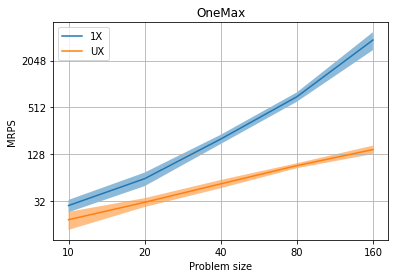

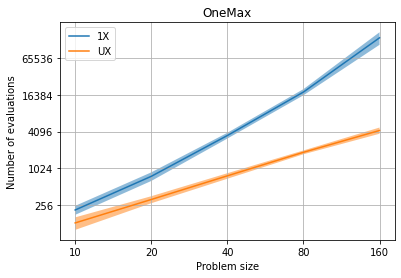

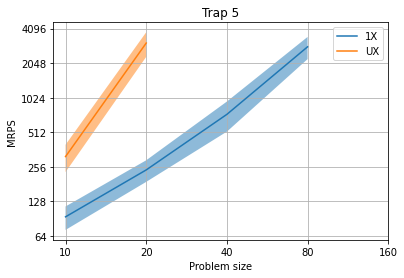

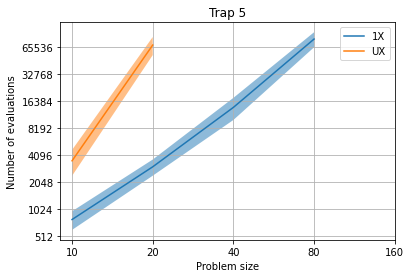

In [ ]:
title_dict = {
    'one_point_crossover': '1X',
    'uniform_crossover': 'UX',
    'onemax': 'OneMax',
    'trap_5': 'Trap 5',
    'n_eval_call': 'Number of evaluations',
    'mrps': 'MRPS',
    }

for problem in lst_problem:
    for ylabel in ['mrps', 'n_eval_call']:
        lines = []
        labels = []
        for variation in lst_variation:
            mean_y = result[problem][variation][ylabel]['mean']
            y_std = result[problem][variation][ylabel]['std']
            assert len(mean_y) == len(y_std)
            x = lst_problem_size[:len(mean_y)]
            lines.append([x, mean_y, y_std])
            labels.append(title_dict[variation])

        plot(lines, labels, title=title_dict[problem], xlabel='Problem size', ylabel=title_dict[ylabel], xticks=lst_problem_size)

In [ ]:
print('Các trường hợp có ý nghĩa thống kê:')
for problem in lst_problem:
    for sample in ['mrps\'', 'mean_n_eval_calls']:
        for problem_size in lst_problem_size:
            a = data[(problem, lst_variation[0], problem_size)][sample]
            b = data[(problem, lst_variation[1], problem_size)][sample]
            
            if None not in a and None not in b and ttest_ind(a,b).pvalue < 0.05:
                print('\t\t\t', problem, problem_size, sample)

Các trường hợp có ý nghĩa thống kê:
			 onemax 10 mrps'
			 onemax 20 mrps'
			 onemax 40 mrps'
			 onemax 80 mrps'
			 onemax 160 mrps'
			 onemax 10 mean_n_eval_calls
			 onemax 20 mean_n_eval_calls
			 onemax 40 mean_n_eval_calls
			 onemax 80 mean_n_eval_calls
			 onemax 160 mean_n_eval_calls
			 trap_5 10 mrps'
			 trap_5 20 mrps'
			 trap_5 10 mean_n_eval_calls
			 trap_5 20 mean_n_eval_calls
